<a href="https://www.kaggle.com/code/prayagkb/code3-forkaggle?scriptVersionId=117930963" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import folium
import geopandas
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns
from random import uniform as uni
import plotly.graph_objects as go
import plotly.express as px
from plotly.graph_objs import Data as Data
from geopy.geocoders import Nominatim
import re
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from warnings import filterwarnings
filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
df = pd.read_csv('../input/data-zomato/data.csv')
df.head(3)

ID Delivery_person_ID Delivery_person_Age Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                   37                     4.9   
1  0xb379     BANGRES18DEL02                   34                     4.5   
2  0x5d6d     BANGRES19DEL01                   23                     4.4   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   

   Delivery_location_longitude  Order_Date Time_Orderd Time_Order_picked  \
0                    75.912471  19-03-2022    11:30:00          11:45:00   
1                    77.813237  25-03-2022    19:45:00          19:50:00   
2                    77.688400  19-03-2022    08:30:00          08:45:00   

       Weatherconditions Road_traffic_density  Vehicle_condition  \
0       conditions Sunny                High                   2   
1      conditions Stormy                 Jam                   2   
2  conditions Sandstorms                 Low                   0   

  Type_of_order Type_of_vehicle multiple_deliveries Festival            City  \
0        Snack      motorcycle                    0      No           Urban    
1        Snack         scooter                    1      No   Metropolitian    
2       Drinks      motorcycle                    1      No           Urban    

  Time_taken(min)  
0        (min) 24  
1        (min) 33  
2        (min) 26

In [3]:
df.replace('NaN ',np.nan,inplace=True)

In [4]:
null_rows = df[df.isnull().any(axis=1)]
df.drop(null_rows.index,axis=0,inplace=True)

In [5]:
df['Delivery_person_Age'] = df['Delivery_person_Age'].apply(lambda x:int(x))
df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].apply(lambda x:float(x))

In [6]:
df.drop(df[(df.Restaurant_latitude==0) | (df.Restaurant_longitude==0) | (df.Delivery_location_longitude==0) | (df.Delivery_location_latitude==0)].index,inplace=True)

In [7]:
def get_distance(r_lat,r_long,d_lat,d_long):
    start_location = [r_lat,r_long]
    end_location = [d_lat,d_long]
    route = distance.distance(start_location, end_location).km
    return round(route,2)

df['distance'] = df[['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude','Delivery_location_longitude']].apply(lambda x: get_distance(*x), axis=1)

df.drop(df[df.distance>50].index,inplace=True)

In [8]:
def get_city_intials(string):
    match = re.search(r"(.*)RES", string)
    if match:
        before_res = match.group(1)
        return before_res

df['City_Initials'] = df['Delivery_person_ID'].apply(get_city_intials)

df['City_Name'] = df['City_Initials'].map({'INDO':'Indore','BANG':'Bangalore','COIMB':'Coimbatore','CHEN':'Chennai',
                                      'HYD':'Hydrabad','RANCHI':'Ranchi','MYS':'Mysore','DEH':'Delhi',
                                      'KOC':'Kochi','PUNE':'Pune','LUDH':'Ludhiana','KNP':'Kanpur','MUM':'Mumbai',
                                      'KOL':'Kolkata','JAP':'Jaipur','SUR':'Surat','GOA':'Goa','AURG':'Aurangabad',
                                      'AGR':'Agra','VAD':'Vadodara','ALH':'Prayagraj','BHP':'Bhopal'})

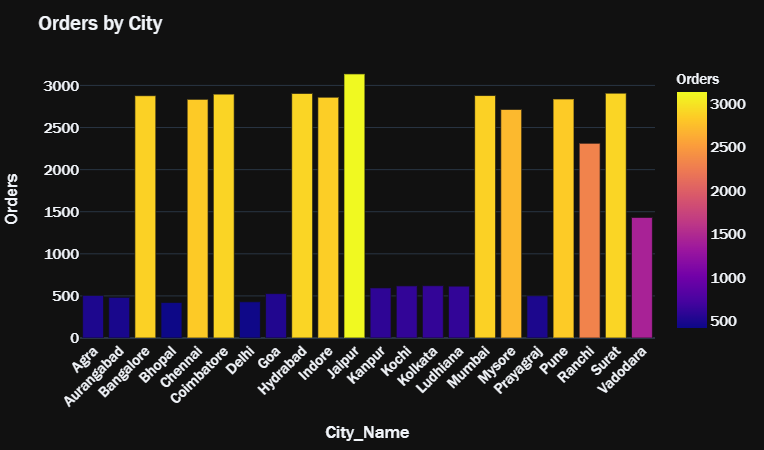

In [9]:
Orders_by_City_dict = df.groupby(['City_Name']).ID.count()
Orders_by_City = pd.DataFrame(columns=['City_Name','Orders'])
Orders_by_City['City_Name'] = Orders_by_City_dict.keys()
Orders_by_City['Orders'] = Orders_by_City_dict.values

fig = px.bar(data_frame=Orders_by_City,x='City_Name',y='Orders',color='Orders')
fig.layout.template = "plotly_dark"
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(title='Orders by City')
fig.show()

In [10]:
def get_lat(city):
    locator = Nominatim(user_agent="myGeocoder")
    location = locator.geocode(city)
    return location.raw['lat']

Orders_by_City['Latitude'] = Orders_by_City.City_Name.apply(get_lat)

def get_long(city):
    locator = Nominatim(user_agent="myGeocoder")
    location = locator.geocode(city)
    return location.raw['lon']

Orders_by_City['Longitude'] = Orders_by_City.City_Name.apply(get_long)

In [11]:
Orders_by_City.loc[Orders_by_City['City_Name']=='Surat','Latitude']=21.170240
Orders_by_City.loc[Orders_by_City['City_Name']=='Surat','Longitude']=72.831062
Orders_by_City.loc[Orders_by_City['City_Name']=='Hydrabad','Latitude']=17.3850
Orders_by_City.loc[Orders_by_City['City_Name']=='Hydrabad','Longitude']=78.4867

In [12]:
from folium.plugins import MarkerCluster

center_coords = [20.5937, 78.9629]
m = folium.Map(location=center_coords, zoom_start=4)

marker_cluster = MarkerCluster().add_to(m)

data = Orders_by_City

for i in range(len(data)):
    folium.Marker(
        location=[data.iloc[i]['Latitude'], data.iloc[i]['Longitude']],
        popup=data.iloc[i]['City_Name'] + '<br>' + 'Orders: ' + str(data.iloc[i]['Orders']),
        icon=folium.Icon(color='red')
    ).add_to(marker_cluster)

folium.LayerControl().add_to(m)

m

In [13]:
m = folium.Map(location=center_coords, zoom_start=4)

heatmap = folium.plugins.HeatMap(
    data=data[['Latitude', 'Longitude', 'Orders']].values.tolist(),
    name='Orders per City',
    min_opacity=0.2,
    overlay=True,
    control=False
)
heatmap.add_to(m)

folium.LayerControl().add_to(m)

m

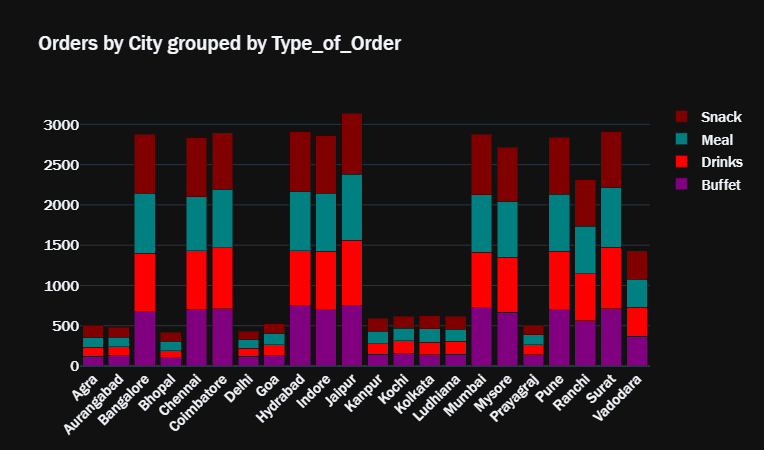

In [51]:
import random
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'lavender', 'brown', 'beige', 'maroon', 'navy', 'olive', 'gray', 'black', 'silver', 'white']
ot_colors = {}
for ot in df['Type_of_order'].unique():
    ot_colors[ot] = random.choice(colors)

colors = ot_colors

df_grouped = df.groupby(['City_Name', 'Type_of_order']).size().reset_index(name='counts')

data = []
for ot in df_grouped['Type_of_order'].unique():
    ot_df = df_grouped[df_grouped['Type_of_order'] == ot]
    trace = go.Bar(x=ot_df['City_Name'], y=ot_df['counts'], name=ot, 
                  marker=dict(color=colors[ot]))
    data.append(trace)

layout = go.Layout(barmode='stack')
fig = go.Figure(data=data, layout=layout)
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(title='Orders by City grouped by Type_of_Order')
fig.layout.template = "plotly_dark"
fig.show()

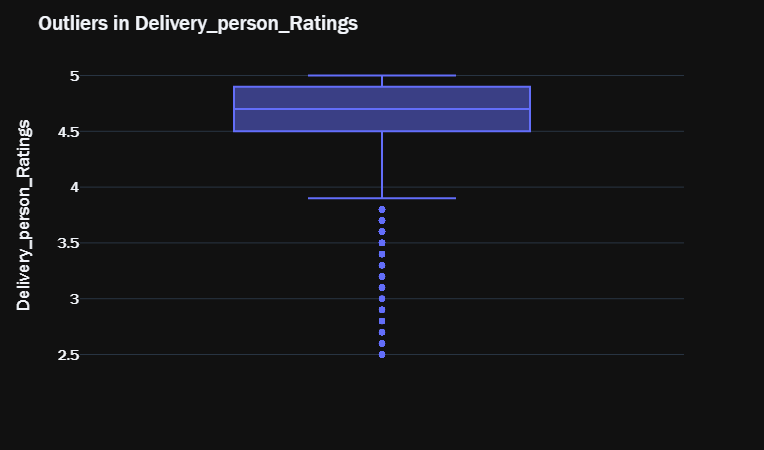

In [15]:
fig = px.box(df, y="Delivery_person_Ratings")
fig.layout.template = "plotly_dark"
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(title='Outliers in Delivery_person_Ratings')
fig.show()

In [16]:
# Dropping ">5" Rating samples
df.drop(df[df.Delivery_person_Ratings>5].index,inplace=True)

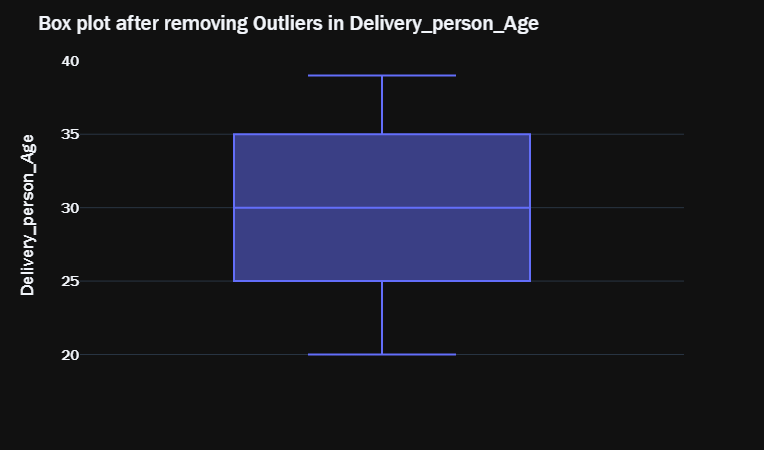

In [17]:
fig = px.box(df, y="Delivery_person_Age")
fig.layout.template = "plotly_dark"
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(title='Box plot after removing Outliers in Delivery_person_Age')
fig.show()

In [18]:
# Keeping the Legal Age only:
df.drop(df[df.Delivery_person_Age<18].index,inplace=True)

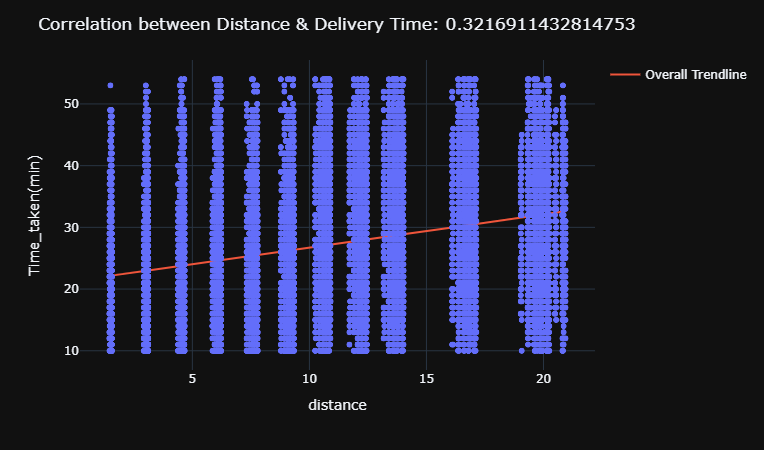

In [19]:
def get_time(string):
    match = re.search(r"\(\w+\) (\d+)", string)
    if match:
        return int(match.group(1))
df['Time_taken(min)'] = df['Time_taken(min)'].apply(get_time)

df['Delivery_person_Age'] = df['Delivery_person_Age'].apply(lambda x:int(x))
df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].apply(lambda x:float(x))

correlation = df['distance'].corr(df['Time_taken(min)'])
fig = px.scatter(df,x='distance',y='Time_taken(min)',trendline="ols",trendline_scope='overall')
fig.update_layout(title=f"Correlation between Distance & Delivery Time: {correlation}")
fig.layout.template = "plotly_dark"
fig.show()

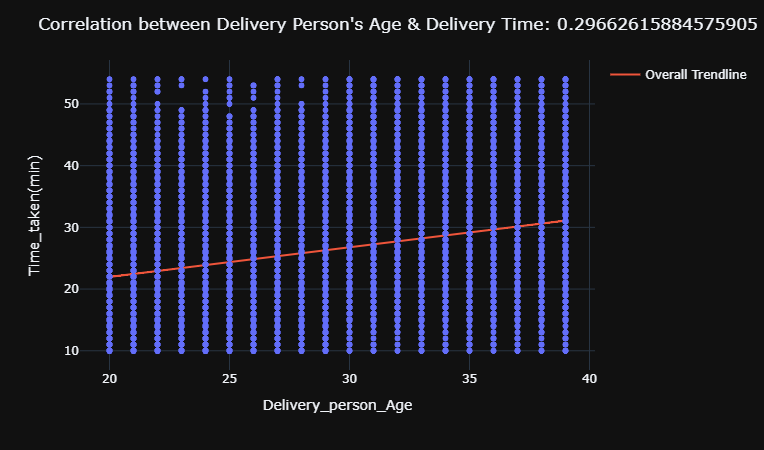

In [20]:
correlation = df['Delivery_person_Age'].corr(df['Time_taken(min)'])
fig = px.scatter(df,x='Delivery_person_Age',y='Time_taken(min)',trendline="ols",trendline_scope='overall')
fig.update_layout(title=f"Correlation between Delivery Person's Age & Delivery Time: {correlation}")
fig.layout.template = "plotly_dark"
fig.show()

In [21]:
def age_bucket(age):
    if age<25:
        return 1
    elif age<30:
        return 2
    elif age<35:
        return 3
    else:
        return 4

df['Age_Bucket'] = df['Delivery_person_Age'].apply(age_bucket)

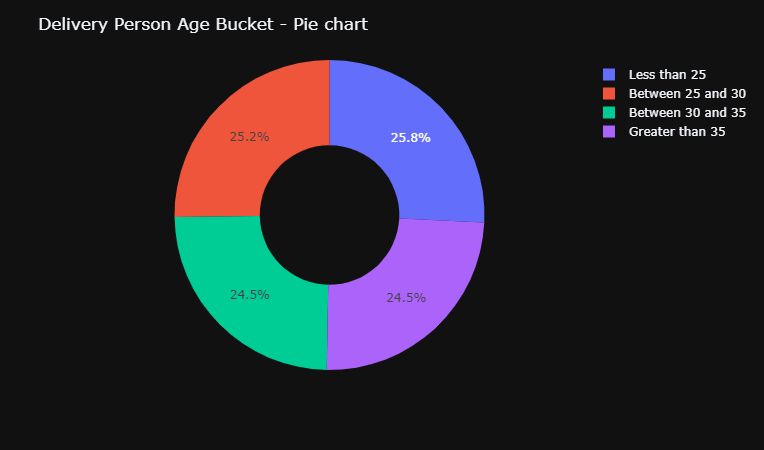

In [22]:
AgeBuckets = ['Less than 25','Between 25 and 30','Between 30 and 35','Greater than 35']
age_bucket_dict = df.Age_Bucket.value_counts().to_dict()
age_bucket_dict = dict(zip(AgeBuckets, list(age_bucket_dict.values())))
fig = px.pie(names=age_bucket_dict.keys(),values=age_bucket_dict.values(),hole=0.45)
fig.update_layout(title="Delivery Person Age Bucket - Pie chart")
fig.layout.template = "plotly_dark"
fig.show()

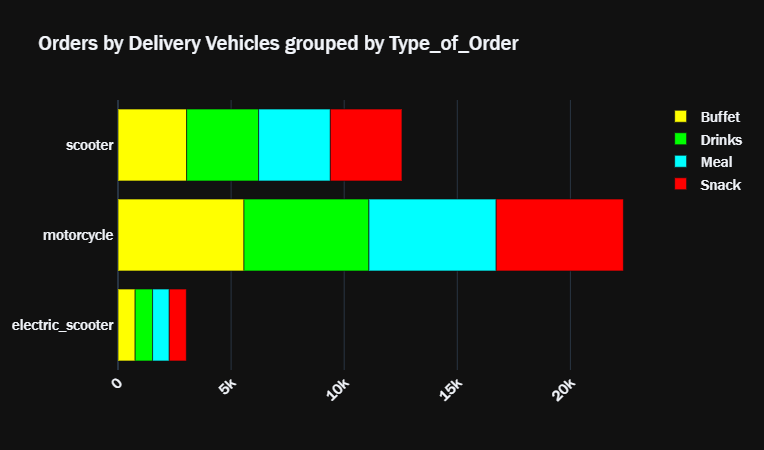

In [23]:
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'lavender', 'brown', 'beige', 'maroon', 'navy', 'olive', 'gray', 'black', 'silver', 'white']
ot_colors = {}
for ot in df['Type_of_order'].unique():
    ot_colors[ot] = random.choice(colors)

colors = ot_colors

df_grouped = df.groupby(['Type_of_vehicle', 'Type_of_order']).size().reset_index(name='counts')

data = []
for ot in df_grouped['Type_of_order'].unique():
    ot_df = df_grouped[df_grouped['Type_of_order'] == ot]
    trace = go.Bar(x=ot_df['counts'], y=ot_df['Type_of_vehicle'], name=ot,orientation='h'
                  ,marker=dict(color=colors[ot]))
    data.append(trace)

layout = go.Layout(barmode='stack')

fig = go.Figure(data=data)
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(barmode='relative')
fig.update_layout(title='Orders by Delivery Vehicles grouped by Type_of_Order')
fig.layout.template = "plotly_dark"
fig.show()

In [24]:
def get_condition(text):
    match = re.search("conditions (.*)", text)

    if match:
        conditions = match.group(1)
        return conditions

df['Weatherconditions'] = df['Weatherconditions'].apply(get_condition)

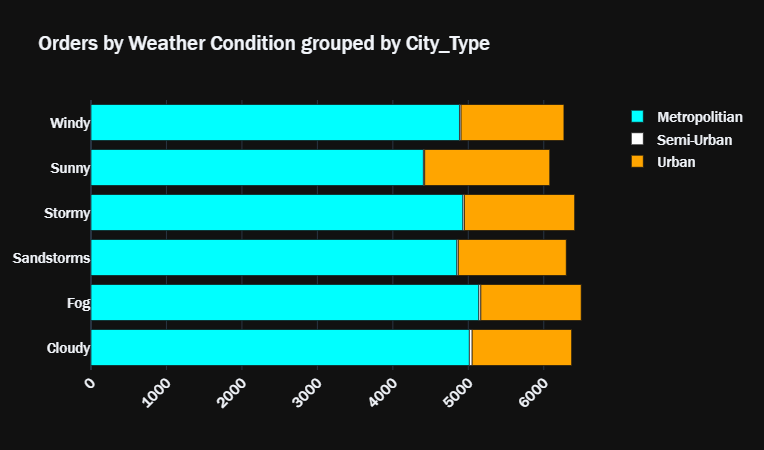

In [25]:
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'lavender', 'brown', 'beige', 'maroon', 'navy', 'olive', 'gray', 'black', 'silver', 'white']
ot_colors = {}
for ot in df['City'].unique():
    ot_colors[ot] = random.choice(colors)

colors = ot_colors

df_grouped = df.groupby(['Weatherconditions', 'City']).size().reset_index(name='counts')

data = []
for ot in df_grouped['City'].unique():
    ot_df = df_grouped[df_grouped['City'] == ot]
    trace = go.Bar(x=ot_df['counts'], y=ot_df['Weatherconditions'], name=ot,orientation='h'
                  ,marker=dict(color=colors[ot]))
    data.append(trace)

layout = go.Layout(barmode='stack')

fig = go.Figure(data=data)
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(barmode='relative')
fig.update_layout(title='Orders by Weather Condition grouped by City_Type')
fig.layout.template = "plotly_dark"
fig.show()

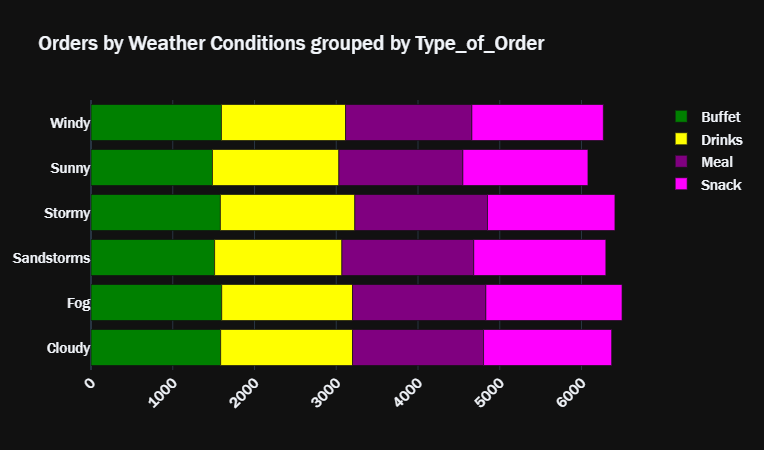

In [26]:
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'lavender', 'brown', 'beige', 'maroon', 'navy', 'olive', 'gray', 'black', 'silver', 'white']
ot_colors = {}
for ot in df['Type_of_order'].unique():
    ot_colors[ot] = random.choice(colors)

colors = ot_colors

df_grouped = df.groupby(['Weatherconditions', 'Type_of_order']).size().reset_index(name='counts')

data = []
for ot in df_grouped['Type_of_order'].unique():
    ot_df = df_grouped[df_grouped['Type_of_order'] == ot]
    trace = go.Bar(x=ot_df['counts'], y=ot_df['Weatherconditions'], name=ot,orientation='h'
                  ,marker=dict(color=colors[ot]))
    data.append(trace)

layout = go.Layout(barmode='stack')

fig = go.Figure(data=data)
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(barmode='relative')
fig.update_layout(title='Orders by Weather Conditions grouped by Type_of_Order')
fig.layout.template = "plotly_dark"
fig.show()

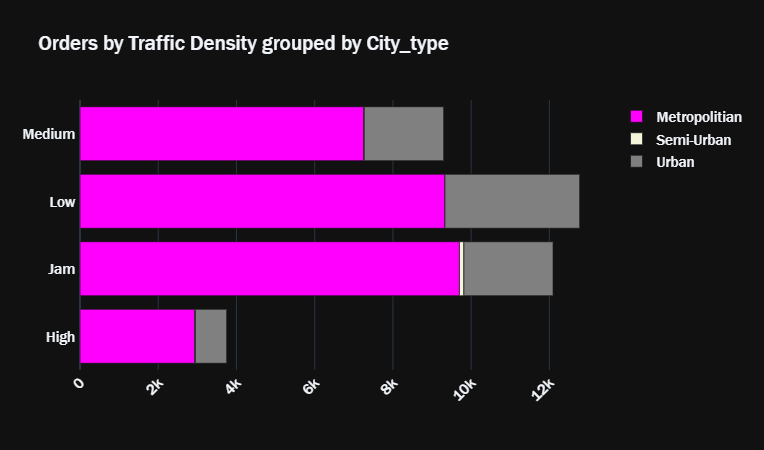

In [57]:
import plotly.graph_objs as go
import random
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'lavender', 'brown', 'beige', 'maroon', 'navy', 'olive', 'gray', 'black', 'silver', 'white']
ot_colors = {}
for ot in df['City'].unique():
    ot_colors[ot] = random.choice(colors)

colors = ot_colors

df_grouped = df.groupby(['Road_traffic_density', 'City']).size().reset_index(name='counts')

data = []
for ot in df_grouped['City'].unique():
    ot_df = df_grouped[df_grouped['City'] == ot]
    trace = go.Bar(x=ot_df['counts'], y=ot_df['Road_traffic_density'], name=ot,orientation='h'
                  ,marker=dict(color=colors[ot]))
    data.append(trace)

layout = go.Layout(barmode='stack')

fig = go.Figure(data=data)
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(barmode='relative')
fig.update_layout(title='Orders by Traffic Density grouped by City_type')
fig.layout.template = "plotly_dark"
fig.show()

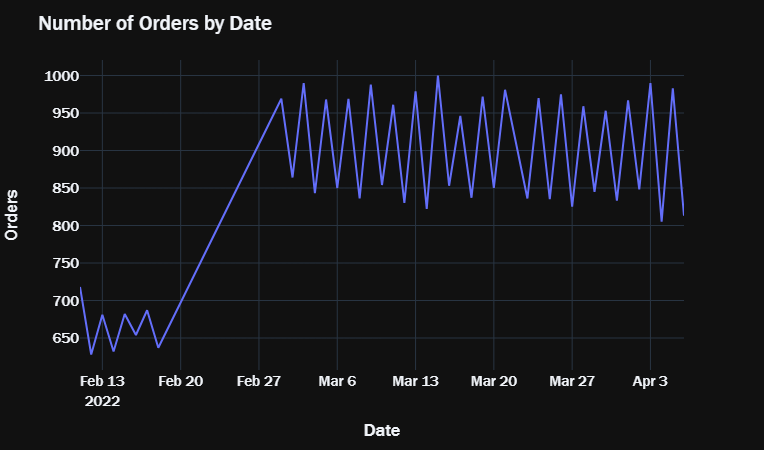

In [28]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'],format='%d-%m-%Y')

Orders_per_day = df.groupby(['Order_Date']).ID.count().to_dict()
Orders_by_Date = pd.DataFrame(columns=['Date','Orders'])
Orders_by_Date['Date'] = Orders_per_day.keys()
Orders_by_Date['Orders'] = Orders_per_day.values()
fig = px.line(Orders_by_Date,x='Date',y='Orders')
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(title='Number of Orders by Date')
fig.layout.template = "plotly_dark"
fig.show()

In [29]:
def bucket_time(time):
    hours = time.hour
    if hours < 4:
        return '0-4'
    elif hours < 8:
        return '4-8'
    elif hours < 12:
        return '8-12'
    elif hours < 16:
        return '12-16'
    elif hours < 20:
        return '16-20'
    else:
        return '20-24'

df['Time_Orderd'] = pd.to_datetime(df['Time_Orderd']).dt.time
df['interval'] = df['Time_Orderd'].apply(bucket_time)

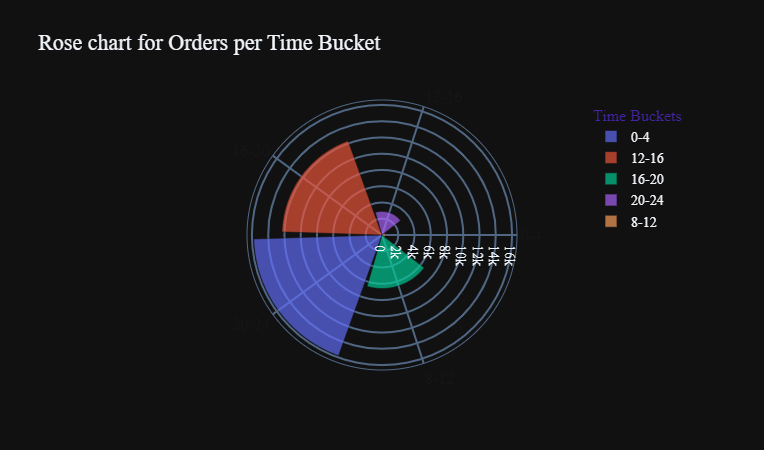

In [30]:
Orders_per_time = df.interval.value_counts().to_dict()
Orders_by_interval = pd.DataFrame(columns=['Time','Orders'])
Orders_by_interval['Time'] = Orders_per_time.keys()
Orders_by_interval['Orders'] = Orders_per_time.values()

### Script taken from open-source.
def rose_chart1(df):
    traces = []
    df_ = df.pivot(columns = "Time",values="Orders")
    for ind,meta in df_.iterrows():
        trace = {
              "name": meta.index[ind], 
              "r": meta.values, 
              "type": "barpolar", 
              "opacity": 1, 
              "theta": df_.columns.values, 
              "hoverinfo": "r+theta",
              "opacity" : 0.68
              }
        traces.append(trace)
    layout = {
      "font": {
        "size": 16, 
        "family": "Overpass"
      }, 
      "polar": {
        "hole": 0.0, 
        "bargap": 0.05,  
        "radialaxis": {
          "visible":True,
          "type": "linear", 
          "title": {"text": "<br>"}, 
          "tickmode": "auto", 
          "tickfont": {"size": 14}, 
          "autorange": True, 
          "gridwidth": 2,
          "linewidth": 0
        }, 
        "angularaxis": {
          "type": "category", 
          "ticklen": 12, 
          "tickmode":"auto",
          "tickfont": {"color": "rgb(22, 22, 22)"}, 
          "direction": "counterclockwise", 
          "gridwidth": 2, 
          "tickwidth": 1, 
          "tickprefix": ""
        }
      }, 
      "title": {"text": "Rose chart for Orders per Time Bucket"}, 
      "xaxis": {
        "range": [-1, 6], 
        "autorange": True
      }, 
      "yaxis": {
        "range": [-1, 4], 
        "autorange": True
      }, 
      "legend": {
        "x": 1, 
        "y": 1, 
        "font": {
          "size": 14, 
          "family": "Roboto"
        }, 
        "title": {
          "font": {
            "size": 16, 
            "color": "rgb(67, 36, 167)", 
            "family": "Overpass"
          }, 
          "text": "Time Buckets"
        }, 
        "xanchor": "auto", 
        "itemsizing": "trace", 
        "traceorder": "normal", 
        "borderwidth": 0, 
        "orientation": "v"
      }, 
      "modebar": {
        "color": "rgba(68, 68, 68, 0.3)", 
        "bgcolor": "rgba(118, 6, 6, 0.5)", 
        "orientation": "h"
      }, 
      "autosize": True, 
      "template": {
        "data": {
          "bar": [
            {
              "type": "bar", 
              "marker": {"colorbar": {
                  "len": 0.2, 
                  "ticks": "inside", 
                  "ticklen": 6, 
                  "tickcolor": "rgb(237,237,237)", 
                  "outlinewidth": 0
                }}
            }
          ], 
          "carpet": [
            {
              "type": "carpet", 
              "aaxis": {
                "gridcolor": "white", 
                "linecolor": "white", 
                "endlinecolor": "rgb(51,51,51)", 
                "minorgridcolor": "white", 
                "startlinecolor": "rgb(51,51,51)"
              }, 
              "baxis": {
                "gridcolor": "white", 
                "linecolor": "white", 
                "endlinecolor": "rgb(51,51,51)", 
                "minorgridcolor": "white", 
                "startlinecolor": "rgb(51,51,51)"
              }
            }
          ], 
        }, 
        "layout": {
          "geo": {
            "bgcolor": "white", 
            "showland": True, 
            "lakecolor": "white", 
            "landcolor": "rgb(237,237,237)", 
            "showlakes": True, 
            "subunitcolor": "white"
          }, 
          "font": {"color": "rgb(51,51,51)","family": "Overpass"}, 
          "polar": {
            "bgcolor": "rgb(237,237,237)", 
            "angularaxis": {
              "ticks": "outside", 
              "showgrid": True, 
              "gridcolor": "white", 
              "linecolor": "white", 
              "tickcolor": "rgb(51,51,51)"
            },
          },   
          "hovermode": "closest", 
          "plot_bgcolor": "rgb(237,237,237)", 
          "paper_bgcolor": "white", 
          "shapedefaults": {
            "line": {"width": 0}, 
            "opacity": 0.3, 
            "fillcolor": "black"}, 
          "annotationdefaults": {
            "arrowhead": 0, 
            "arrowwidth": 1}
        }
      }, 
      "coloraxis": {"cauto": True}, 
      "separators": ", "
    }    

    data = Data(traces)
    fig = go.Figure(data,layout)
    fig.layout.template = "plotly_dark"
    fig.show()

rose_chart1(Orders_by_interval)

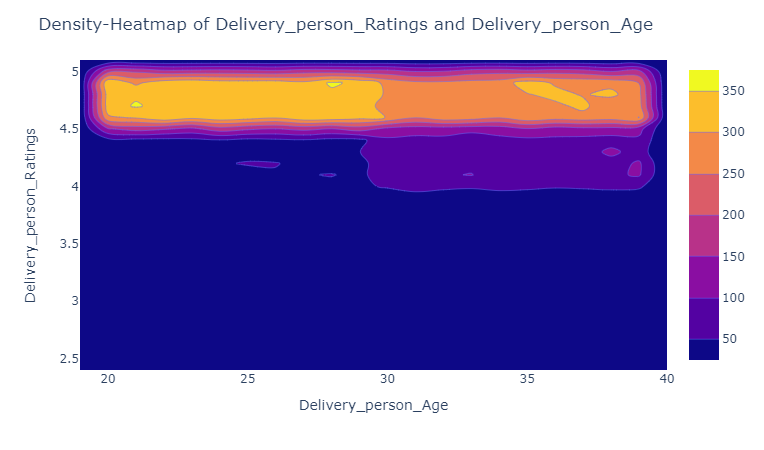

In [31]:
fig = px.density_contour(df,x='Delivery_person_Age',y='Delivery_person_Ratings')
fig.update_traces(contours_coloring="fill")
#fig.layout.template = "plotly_dark"
fig.update_layout(title='Density-Heatmap of Delivery_person_Ratings and Delivery_person_Age')
fig.show()

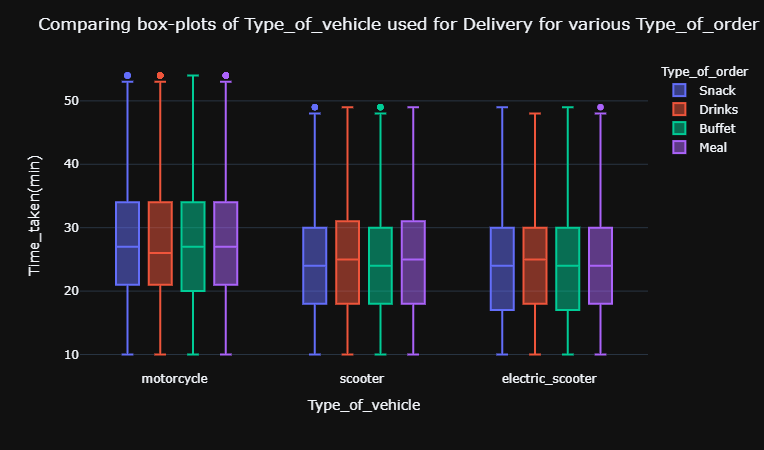

In [32]:
fig = px.box(df, 
             x="Type_of_vehicle",
             y="Time_taken(min)", 
             color="Type_of_order")
fig.layout.template='plotly_dark'
fig.update_layout(title='Comparing box-plots of Type_of_vehicle used for Delivery for various Type_of_order against time')
fig.show()

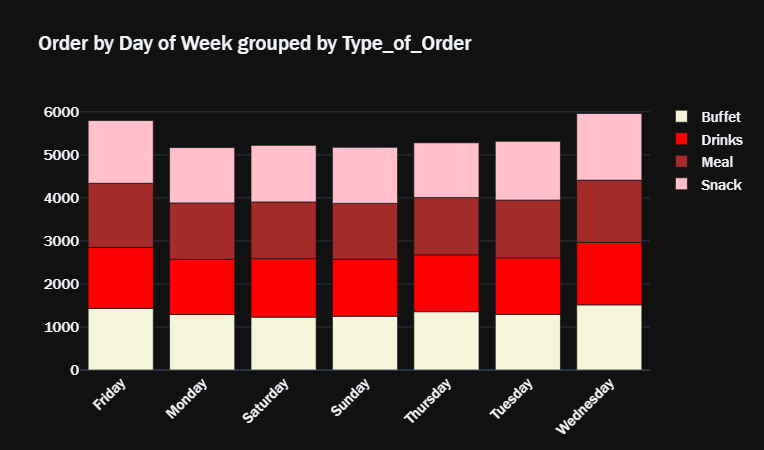

In [59]:
df['Day'] = pd.to_datetime(df.Order_Date).dt.day_name()
colors = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'lime', 'teal', 'lavender', 'brown', 'beige', 'maroon', 'navy', 'olive', 'gray', 'black', 'silver', 'white']
ot_colors = {}
for ot in df['Type_of_order'].unique():
    ot_colors[ot] = random.choice(colors)

colors = ot_colors

df_grouped = df.groupby(['Day', 'Type_of_order']).size().reset_index(name='counts')

data = []
for ot in df_grouped['Type_of_order'].unique():
    ot_df = df_grouped[df_grouped['Type_of_order'] == ot]
    trace = go.Bar(x=ot_df['Day'], y=ot_df['counts'], name=ot,orientation='v'
                  ,marker=dict(color=colors[ot]))
    data.append(trace)

layout = go.Layout(barmode='stack')

fig = go.Figure(data=data)
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(barmode='relative')
fig.update_layout(title='Order by Day of Week grouped by Type_of_Order')
fig.layout.template = "plotly_dark"
fig.show()

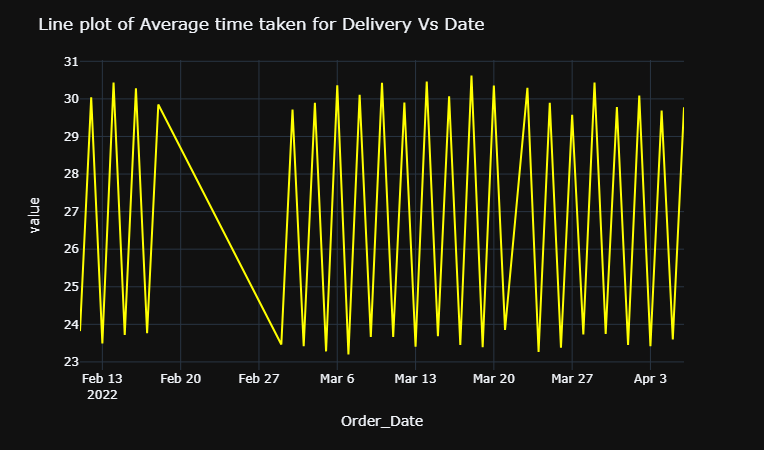

In [34]:
date_df_dict = df.groupby(['Order_Date'])['Time_taken(min)'].mean().to_dict()
date_df = pd.DataFrame(columns=['Order_Date','Avg'])
date_df['Order_Date']=date_df_dict.keys()
date_df['Time_taken(min)']=date_df_dict.values()
date_df.index = date_df['Order_Date']
date_df.drop('Order_Date',axis=1,inplace=True)
fig = px.line(date_df.drop('Avg',axis=1))
fig.update_traces(line_color='yellow')
fig.update_layout(showlegend=False)
fig.update_layout(title='Line plot of Average time taken for Delivery Vs Date')
fig.layout.template = "plotly_dark"
fig.show()

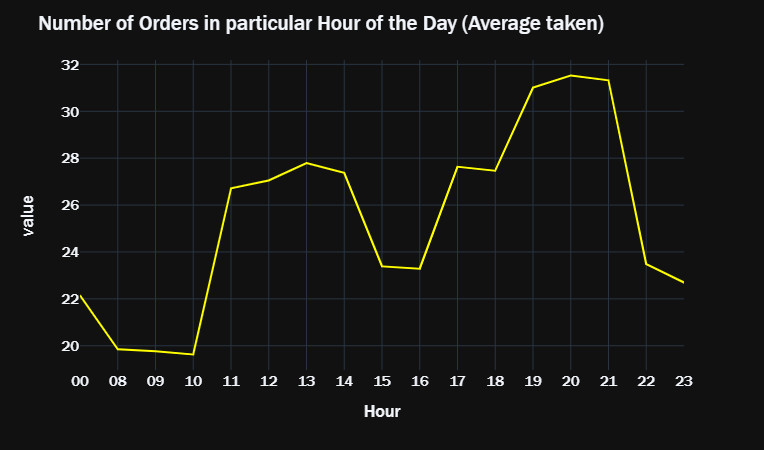

In [35]:
time_df = df[['ID','Time_Orderd','Time_taken(min)']]
time_df['Hour'] = time_df['Time_Orderd'].apply(lambda x: x.strftime('%H'))
time_df_grouped = time_df.groupby('Hour').mean()
fig = px.line(time_df_grouped)
fig.update_traces(line_color='yellow')
fig.update_layout(showlegend=False)
fig.update_layout(title='Number of Orders in particular Hour of the Day (Average taken)')
fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
fig.layout.template = "plotly_dark"
fig.show()

In [36]:
df['Hour'] = df['Time_Orderd'].apply(lambda x: x.strftime('%H'))

In [37]:
def outliers(df,ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    
    IQR = Q3-Q1
    
    lower = Q1-1.5*IQR
    upper = Q3+1.5*IQR
    
    ls = df.index [ (df[ft]< lower) | (df[ft] > upper) ]
    
    return ls

Delivery_time_taken_outliers = outliers(df,'Time_taken(min)')
print(f'Outliers in Time_taken(min): {len(Delivery_time_taken_outliers)}')
df.drop(Delivery_time_taken_outliers,axis=0,inplace=True)
print("Droppeddd !!!")

Outliers in Time_taken(min): 0
Droppeddd !!!


# Model Building

# ---------------------------------------------------------------

In [38]:
### Dropping irrelavant columns

irrelavant_cols = ['ID','Delivery_person_ID','Restaurant_latitude','Restaurant_longitude',
                   'Delivery_location_latitude','Delivery_location_longitude','City_Initials',
                   'Time_Order_picked','Age_Bucket','multiple_deliveries','Festival','Age_Bucket',
                   'interval','City_Initials','Order_Date','Time_Orderd']
model_df = df.drop(irrelavant_cols,axis=1)

<AxesSubplot:>

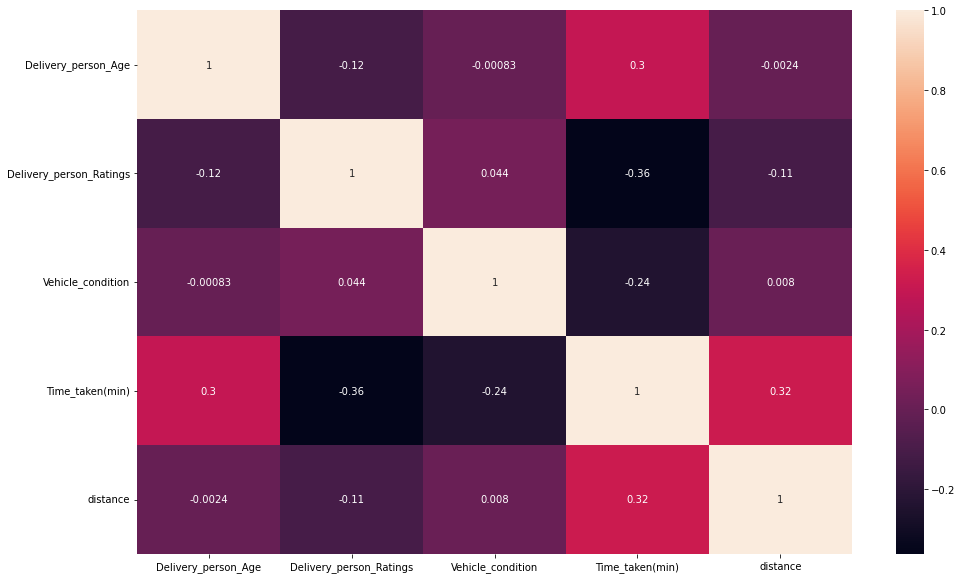

In [39]:
plt.figure(figsize=(16,10))
sns.heatmap(model_df[['Delivery_person_Age','Delivery_person_Ratings','Vehicle_condition','Time_taken(min)','distance']].corr(),annot=True)

In [40]:
### Onehot Encoding / Pandas dummies for categorical variables

dummies = {}
for ft in ['Type_of_order','Type_of_vehicle','City','Weatherconditions',
           'Road_traffic_density','Type_of_order','Type_of_vehicle','City','City_Name', 'Day']:
    dummies[ft] = pd.get_dummies(model_df[ft])

sum([dummies[dummy].shape[1] for dummy in dummies.keys()])

49

In [41]:
model_df.drop(dummies.keys(),axis=1,inplace=True)

for dummy in dummies:
    model_df = pd.concat([model_df,dummies[dummy]],axis=1)
    
model_df.head(3)

Delivery_person_Age  Delivery_person_Ratings  Vehicle_condition  \
0                   37                      4.9                  2   
1                   34                      4.5                  2   
2                   23                      4.4                  0   

   Time_taken(min)  distance Hour  Buffet   Drinks   Meal   Snack   ...  \
0               24      3.02   11        0        0      0       1  ...   
1               33     20.14   19        0        0      0       1  ...   
2               26      1.55   08        0        1      0       0  ...   

   Ranchi  Surat  Vadodara  Friday  Monday  Saturday  Sunday  Thursday  \
0       0      0         0       0       0         1       0         0   
1       0      0         0       1       0         0       0         0   
2       0      0         0       0       0         1       0         0   

   Tuesday  Wednesday  
0        0          0  
1        0          0  
2        0          0  

[3 rows x 55 columns]

In [42]:
X = model_df.drop('Time_taken(min)',axis=1)
y = model_df['Time_taken(min)']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(X.iloc[:,:5])
X.iloc[:,:5] = scaled
X.head(3)

Delivery_person_Age  Delivery_person_Ratings  Vehicle_condition  distance  \
0             1.282524                 0.845853           1.229244 -1.202318   
1             0.761930                -0.416083           1.229244  1.858369   
2            -1.146913                -0.731568          -1.217179 -1.465122   

       Hour  Buffet   Drinks   Meal   Snack   electric_scooter   ...  Ranchi  \
0 -1.343605        0        0      0       1                  0  ...       0   
1  0.326481        0        0      0       1                  0  ...       0   
2 -1.969888        0        1      0       0                  0  ...       0   

   Surat  Vadodara  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
0      0         0       0       0         1       0         0        0   
1      0         0       1       0         0       0         0        0   
2      0         0       0       0         1       0         0        0   

   Wednesday  
0          0  
1          0  
2          0  

[3 rows x 54 columns]

In [43]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

from sklearn.linear_model import LinearRegression
ln = LinearRegression()
ln.fit(X_train,y_train)

LinearRegression()

In [44]:
ln.score(X_test,y_test)

0.5364049890422027

In [45]:
from xgboost import XGBRegressor
xgbr = XGBRegressor()
xgbr.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [46]:
xgbr.score(X_train,y_train)

0.8727490571338792

In [47]:
xgbr.score(X_test,y_test)

0.8168659254153063

In [48]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()
cat.fit(X_train,y_train)

Learning rate set to 0.070198
0:	learn: 8.8893179	total: 63.8ms	remaining: 1m 3s
1:	learn: 8.4977523	total: 71.4ms	remaining: 35.6s
2:	learn: 8.1456832	total: 77.4ms	remaining: 25.7s
3:	learn: 7.8218911	total: 83.2ms	remaining: 20.7s
4:	learn: 7.5337668	total: 89.5ms	remaining: 17.8s
5:	learn: 7.2684015	total: 95.2ms	remaining: 15.8s
6:	learn: 7.0458354	total: 101ms	remaining: 14.3s
7:	learn: 6.8309487	total: 106ms	remaining: 13.1s
8:	learn: 6.6345233	total: 112ms	remaining: 12.4s
9:	learn: 6.4262313	total: 117ms	remaining: 11.6s
10:	learn: 6.2676525	total: 122ms	remaining: 11s
11:	learn: 6.1181037	total: 128ms	remaining: 10.5s
12:	learn: 5.9834137	total: 133ms	remaining: 10.1s
13:	learn: 5.8572108	total: 138ms	remaining: 9.69s
14:	learn: 5.7331897	total: 143ms	remaining: 9.37s
15:	learn: 5.6235222	total: 148ms	remaining: 9.09s
16:	learn: 5.4989738	total: 153ms	remaining: 8.84s
17:	learn: 5.4059236	total: 158ms	remaining: 8.61s
18:	learn: 5.3165964	total: 163ms	remaining: 8.4s
19:	lear

In [49]:
cat.score(X_train,y_train)

0.8589464302065981

In [50]:
cat.score(X_test,y_test)

0.8250073285020979